In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Parameters characterizing the model

All parameters used later are defined globally here. To do different tests, change the parameters here and **rerun all the relevant cells to ensure using the new parameters**.

In [20]:
# parameters
rho = 0.1               # AR(1) correlation
sigma = 0.1             # AR(1) variant
delta = 0.05            # capital depreciation rate
alpha = 0.3             # Cobb-Douglas parameter
beta = 0.96             # discount factor
w = 5                   # wage rate if fixed. would be modified later     
k_init = 5              # initial capital if transform from worker to entrepreneur
z0 = 0                  # time 0 productivity shock
kmin = 0                # capital lower bound
kmax = 40               # capital upper bound
zmin = -0.4             # shock lower bound, see experiment below
zmax = 0.4              # shock upper bound, see experiment below
grid_size = 100         # basic grid size
ksize = grid_size
asize = grid_size
zsize = grid_size * 2
kgrid = np.linspace(kmin, kmax, ksize)
agrid = np.linspace(kmin, kmax, asize)  # worker's asset is treated equivalent to entrepreneur's capital
zgrid = np.linspace(zmin, zmax, zsize)
pi = alpha * ((1 - alpha) / w)**((1-alpha)/alpha)   # the derived parameter in entrepreneur dividend function

# 2. Shock Simulation to get bounds

The below function generate one single sequence of shocks:

In [21]:
def simulate_shock(z0=z0, rho=rho, sigma=sigma, T=100):   # use the parameter defined globally above
    z = z0
    zs = [z0]
    for i in range(T):
        z = rho * z + sigma * np.random.normal()
        zs.append(z)
    return zs

We simulate 100 sequences to see what is the valid upper/lower bound for grids. 

We can see almost all the sequences are bounded by [-0.4, 0.4].

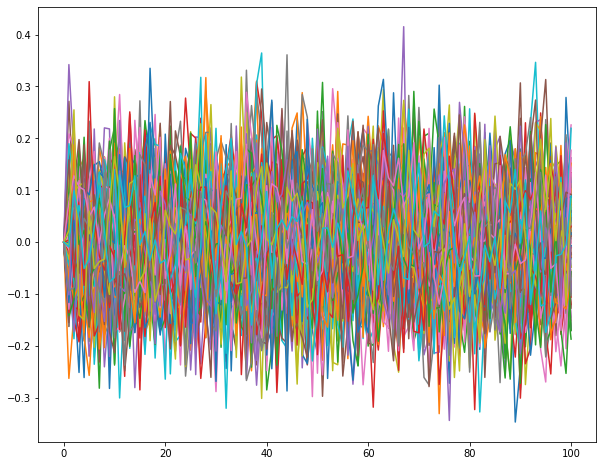

-0.3468313753169156 0.41527428517468246


In [22]:
N = 100
zmin, zmax = 0, 0
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(N):
    zs = simulate_shock()
    if zmin > min(zs): zmin = min(zs)
    if zmax < max(zs): zmax = max(zs)
    ax.plot(range(len(zs)), zs)
plt.show()
print(zmin, zmax)

# 3. Build a Model Class to store everything

In [23]:
class AiyagariChoice:
    
    def __init__(self, rho=rho, sigma=sigma, delta=delta, alpha=alpha, beta=beta, 
                 w=w, k_init=k_init, z0=z0, kmin=kmin, kmax=kmax, zmin=zmin, zmax=zmax, grid_size=grid_size):
        
        # store the parameters
        self.rho = rho
        self.sigma = sigma
        self.delta = delta
        self.alpha = alpha
        self.beta = beta
        self.w = w
        self.k_init = k_init
        self.z0 = z0
        self.ksize = grid_size
        self.asize = grid_size
        self.zsize = grid_size * 2
        self.kgrid = np.linspace(kmin, kmax, self.ksize)
        self.agrid = np.linspace(kmin, kmax, self.asize)
        self.zgrid = np.linspace(zmin, zmax, self.zsize)
        self.pi = alpha * ((1 - alpha) / w)**((1-alpha)/alpha)
        
        # define in advance the matrices we would use later
        # pure means no occupation choices are permitted
        # mixed means otherwise
        
        # Entreprenuer's value functions in two cases, shape K * Z
        self.EV1 = np.zeros((self.ksize, self.zsize), dtype=np.float32)
        self.EV2 = np.zeros((self.ksize, self.zsize), dtype=np.float32)
        
        # Worker's value functions in two cases, shape K
        self.WV1 = np.zeros(self.asize, dtype=np.float32)       
        self.WV2 = np.zeros(self.asize, dtype=np.float32)
        
        # Entreprenuer's policy function (for k') in two cases, shape K * Z
        self.ESigma1 = np.zeros((self.ksize, self.zsize), dtype=np.float32)
        self.ESigma2 = np.zeros((self.ksize, self.zsize), dtype=np.float32)
        
        # notice here:
            # entrepreneur first choose next k, then depend on next z he choose to be W or E
            # so here the state space for decision is (k', z')
            # same for worker, the state space is (z')
        self.EtoE = np.zeros((self.ksize, self.zsize), dtype=bool)
        self.WtoE = np.zeros(self.zsize, dtype=bool)
        
        # these two matrices help in solve Entrepreneur's k prime decision problem
        # EP is the transition matrix, storing the conditional distribution P(z'|z). Row for z, Column for z'
        # ER is the reward matrix, store the reward for each state-action pair: (k, z) and k'
        self.EP = np.zeros((self.zsize, self.zsize), dtype=np.float32)
        self.ER = np.empty((self.ksize, self.zsize, self.ksize), dtype=np.float32)
        
        # vectorize the utility function so it can proceed an array of consumption for later usage
        self.u_ = np.vectorize(self.u)
        
        # build the transition matrix and reward matrix, see below
        self.populate_EP()
        self.populate_ER()
        
        # solve E's and W's problem when no occupation choice
        self.solveEV1()
        self.solveWV1()
        
        # solve E's and W's problem together when allowing occupation choice
        self.solveV2()
        
    # our k lower bound is 0(first grid) and the second grid is larger than 0.001, 
    # so we bounded below the utility by log(0.001), an arbitrary small number 
    def u(self, c):
        return np.log(c) if c > 0 else np.log(1e-3)

    # this function return the upper bound available action index given a state index (k_idx, z_idx)
    # so we only need to update the value of indices below in the value matrix
    def feasible_k_idx(self, k_idx, z_idx):
        
        # from idx to grid point value
        k, z = self.kgrid[k_idx], self.zgrid[z_idx]
        # calculate the dividend d
        d = np.exp(z / self.alpha) * self.pi * k
        # impose budget constraint
        k_bound = d + (1 - self.delta) * k
        # from value to idx, notice that the k_bound_idx is inclusive
        # k_bound is the closest point in k grid to d + (1 - self.delta) * k
        k_bound_idx = np.where(self.kgrid <= k_bound)[0][-1]
        return k_bound_idx
        
    # this function calculate the pdf of each grid point z' given the current z' index and normalize
    def conditional_probability(self, z_idx):
        z = self.zgrid[z_idx]
        mu = self.rho * z
        z_prime_dist = norm(mu, self.sigma)
        z_prime_pdf = z_prime_dist.pdf(self.zgrid)
        # normalize the pdf to be sum to 1
        z_prime_pdf /= z_prime_pdf.sum()
        return z_prime_pdf
    
    # this function calculate the pdf of each grid point z' from the ergodic distribution in W's problem
    def unconditional_probability(self):
        z_prime_dist = norm(0, np.sqrt(self.sigma**2 / (1 - self.rho)))
        z_prime_pdf = z_prime_dist.pdf(self.zgrid)
        z_prime_pdf /= z_prime_pdf.sum()
        return z_prime_pdf
    
    # build the transition matrix P using conditional probability
    def populate_EP(self):
        for z_idx in range(self.zsize):
            self.EP[z_idx, :] = self.conditional_probability(z_idx)
    
    # build the reward matrix R used in VFI
    # We first fill all elements in the matrix with minus infinity, then we begin to fill the value of
    # available action under each state
    # by doing this, during VFI the unavailable actions would be automatically ignored because they are -inf  
    def populate_ER(self):
        # fill -inf
        self.ER.fill(-np.inf)
        # loop over the state (k, z) pair
        for k_idx in range(self.ksize):
            for z_idx in range(self.zsize):
                # get the upper bound idx of action k' for each state (k, z) pair
                k_prime_idx_bound = self.feasible_k_idx(k_idx, z_idx)
                # get the value from the idx
                k_prime_bound = self.kgrid[k_prime_idx_bound]
                # the upper bound is inclusive
                for k_prime_idx in range(k_prime_idx_bound + 1):
                    k_prime = self.kgrid[k_prime_idx]
                    # fill the element (k, z, k') in R matrix with the u(c), 
                    # remember k_bound is the closest point in k grid to d + (1 - self.delta) * k
                    self.ER[k_idx, z_idx, k_prime_idx] = self.u_(k_prime_bound - k_prime)
    
    
    # this function solve entreprenuer's VFI when no occupation choice
    def solveEV1(self):
        EV = np.copy(self.EV1)
        count = 0
        while True:
            count += 1
            # Bellman update
            # R matrix is K * Z * K', P matrix is Z * Z', V matrix is K * Z, so K' * Z' for V'
            # here we multiply P and V' by P @ V'.T to get matrix in the shape Z * K'
            # then we augment one dimension in 0-dim to be 1 * Z * K', so now it can be vectorized
            # to add to the R matrix
            # then we take the maximum over the resulting K * Z * K' matrix, the maximum is over the 2-dim, K'
            EV_ = np.max(self.ER + self.beta * (self.EP @ EV.T)[np.newaxis, :, :], axis=2)
            
            # compute the max of absolute diff between old V and new V
            L1_loss = np.abs(EV_ - EV).max()
            EV[:] = EV_
            if L1_loss < 1e-5:
                print(f'Converged in {count} iterations.')
                break
        self.EV1[:] = EV
        # once the VF is converged, do one Bellman iteration again, 
        # but this time use argmax instead, to get optimal policy
        sigma_idx = np.argmax(self.ER + self.beta * (self.EP @ self.EV1.T)[np.newaxis, :, :], axis=2)
        self.ESigma1 = self.kgrid[sigma_idx]
    
    
    # solve worker's VFI when no choice, basically the same as above but simpler
    def solveWV1(self):
        WV = np.copy(self.WV1)
        count = 0
        while True:
            count+=1
            WV_ = self.u_(self.w + self.agrid) + self.beta*WV[0]
            L1_loss = np.abs(WV_ - WV).max()
            WV[:] = WV_
            if L1_loss < 1e-5:
                print(f'Converged in {count} iterations.')
                break
        self.WV1[:] = WV
    
    # solve both entrepreneur's and worker's VFI when occupation choice
    def solveV2(self):
        
        # this function find the closest index in an array to an given value
        def find_nearest_idx(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        
        EV = np.copy(self.EV2)
        WV = np.copy(self.WV2)
        count = 0
        # find the idx for k_init
        k_init_idx = find_nearest_idx(self.kgrid, self.k_init)
        while True:
            count += 1
            # entrepreneur VFI
            # compare EV' and WV'. EV'.T has shape Z' * K', WV has shape K', so we augment to be Z' * K' 
            EV_target = np.maximum(EV.T, np.tile(WV, (self.zsize, 1)))
            # Bellman update, same as Entrepreneur's VFI when no choice as above
            EV_ = np.max(self.ER + self.beta * (self.EP @ EV_target)[np.newaxis, :, :], axis=2)
            
            # worker VFI
            V = np.maximum(EV[k_init_idx, :], np.tile(WV[0], self.zsize))
            P = self.unconditional_probability()
            WV_target = P @ V
            WV_ = self.u_(self.w + self.agrid) + self.beta * WV_target         
            L1_loss = max(np.abs(EV_ - EV).max(), np.abs(WV_ - WV).max())
                                   
            EV[:], WV[:] = EV_, WV_
                                   
            if L1_loss < 1e-5:
                print(f'Converged in {count} iterations.')
                break
        self.EV2 = EV[:]
        self.WV2 = WV[:]
        
        # after VFI converge, get policy of occupaiton choice and k'
        # compare EV' and WV', augment WV' to has the shape Z' * K' as EV.T
        EtoE = (EV.T > np.tile(WV, (self.zsize, 1))).T
        EV_target = np.maximum(EV.T, np.tile(WV, (self.zsize, 1)))
        sigma_idx = np.argmax(self.ER + self.beta * (self.EP @ EV_target)[np.newaxis, :, :], axis=2)
        self.ESigma2 = self.kgrid[sigma_idx]
        
        # compare EV'(k_init) and WV(0), augment WV(0) to has the shape Z'
        WtoE = EV[k_init_idx, :] > np.tile(WV[0], self.zsize)
        
        self.EtoE = EtoE
        self.WtoE = WtoE
        

In [24]:
model = AiyagariChoice()

Converged in 439 iterations.
Converged in 297 iterations.
Converged in 336 iterations.


We fetch all matrices from our model for plotting figures.

In [25]:
EV1 = model.EV1
WV1 = model.WV1
ESigma1 = model.ESigma1

EV2 = model.EV2
WV2 = model.WV2
ESigma2 = model.ESigma2

EtoE = model.EtoE
WtoE = model.WtoE

# 4. Plotting

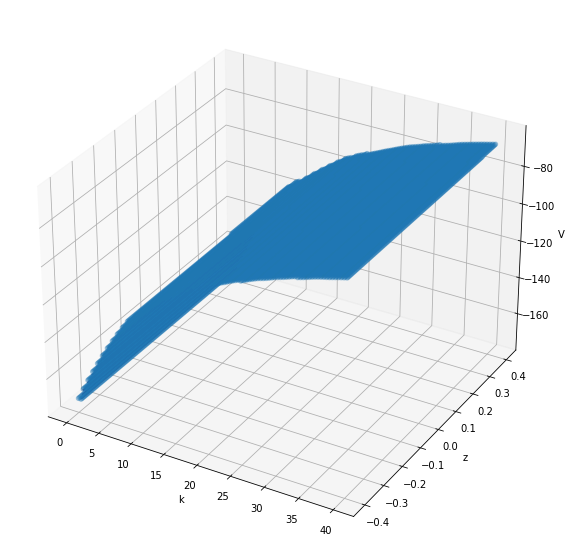

In [26]:
k, z = kgrid, zgrid
kk, zz = np.meshgrid(k, z)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.contour3D(kk, zz, EV1.T, 50)
ax.scatter(kk, zz, EV1.T, alpha=0.3)
ax.set_xlabel('k')
ax.set_ylabel('z')
ax.set_zlabel('V');

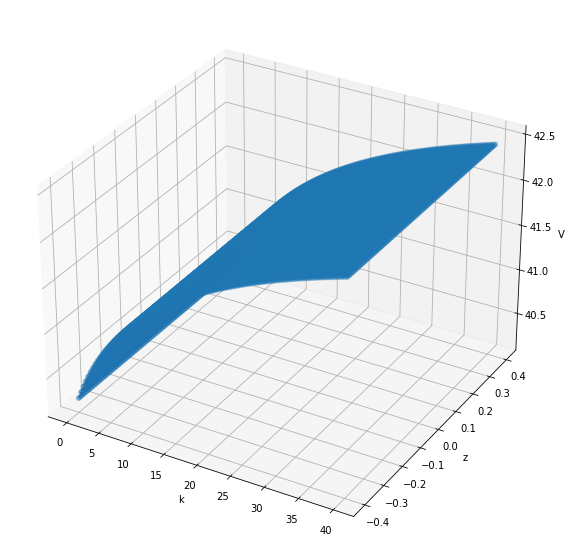

In [27]:
k, z = kgrid, zgrid
kk, zz = np.meshgrid(k, z)

WV1_ = np.tile(WV1, (zsize, 1)).T

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.contour3D(kk, zz, WV1_.T, 50)
ax.scatter(kk, zz, WV1_.T, alpha=0.3)
ax.set_xlabel('k')
ax.set_ylabel('z')
ax.set_zlabel('V');

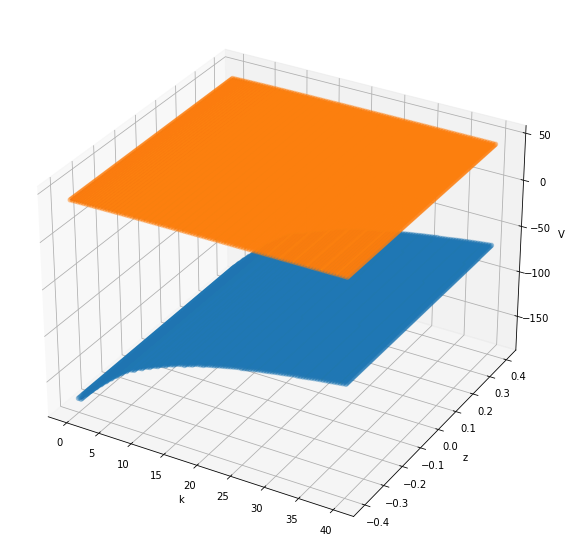

In [28]:
k, z = kgrid, zgrid
kk, zz = np.meshgrid(k, z)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.contour3D(kk, zz, EV1.T, 50)
ax.contour3D(kk, zz, WV1_.T, 50)
ax.scatter(kk, zz, EV1.T, alpha=0.3)
ax.scatter(kk, zz, WV1_.T, alpha=0.3)
ax.set_xlabel('k')
ax.set_ylabel('z')
ax.set_zlabel('V');

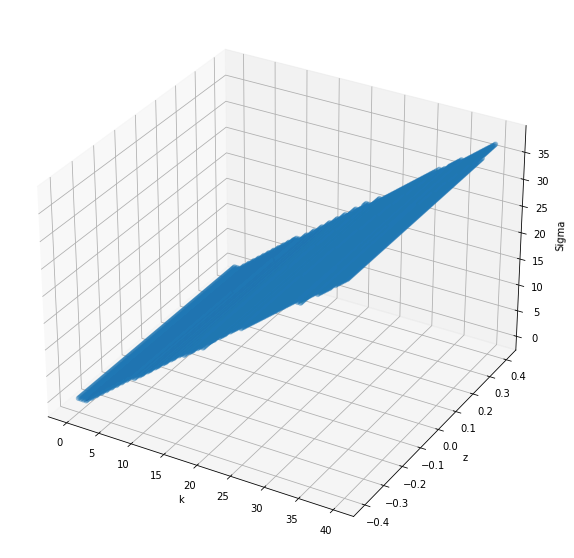

In [29]:
k, z = kgrid, zgrid
kk, zz = np.meshgrid(k, z)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.contour3D(kk, zz, ESigma1.T, 50)
ax.scatter(kk, zz, ESigma1.T, alpha=0.3)
ax.set_xlabel('k')
ax.set_ylabel('z')
ax.set_zlabel('Sigma');

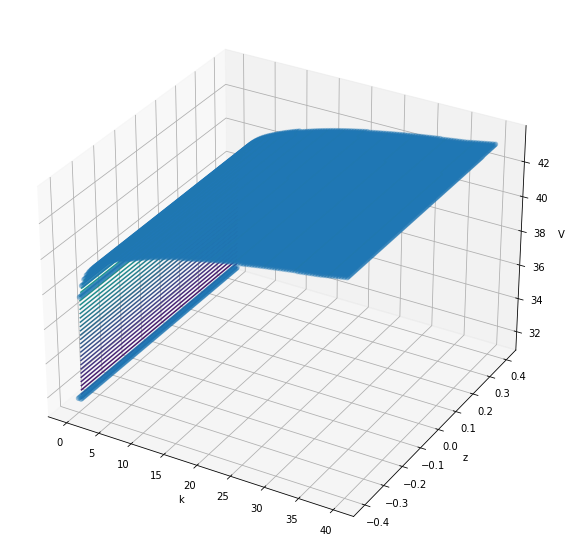

In [30]:
k, z = kgrid, zgrid
kk, zz = np.meshgrid(k, z)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.contour3D(kk, zz, EV2.T, 50)
ax.scatter(kk, zz, EV2.T, alpha=0.3)
ax.set_xlabel('k')
ax.set_ylabel('z')
ax.set_zlabel('V');

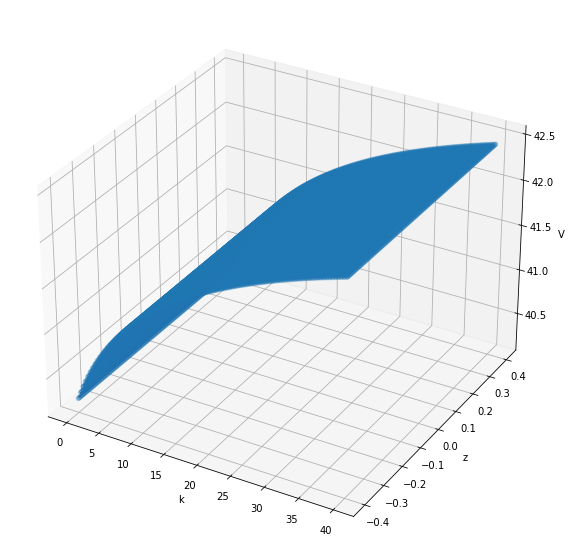

In [31]:
k, z = kgrid, zgrid
kk, zz = np.meshgrid(k, z)

WV2_ = np.tile(WV2, (zsize, 1)).T

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.contour3D(kk, zz, WV2_.T, 50)
ax.scatter(kk, zz, WV2_.T, alpha=0.3)
ax.set_xlabel('k')
ax.set_ylabel('z')
ax.set_zlabel('V');

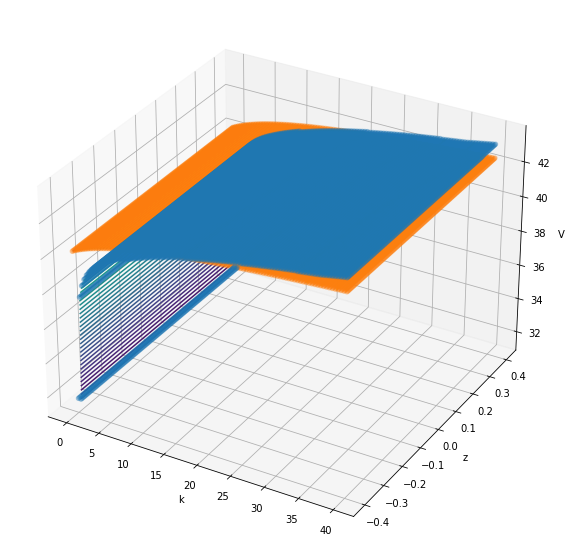

In [32]:
k, z = kgrid, zgrid
kk, zz = np.meshgrid(k, z)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.contour3D(kk, zz, EV2.T, 50)
ax.contour3D(kk, zz, WV2_.T, 50)
ax.scatter(kk, zz, EV2.T, alpha=0.3)
ax.scatter(kk, zz, WV2_.T, alpha=0.3)
ax.set_xlabel('k')
ax.set_ylabel('z')
ax.set_zlabel('V');

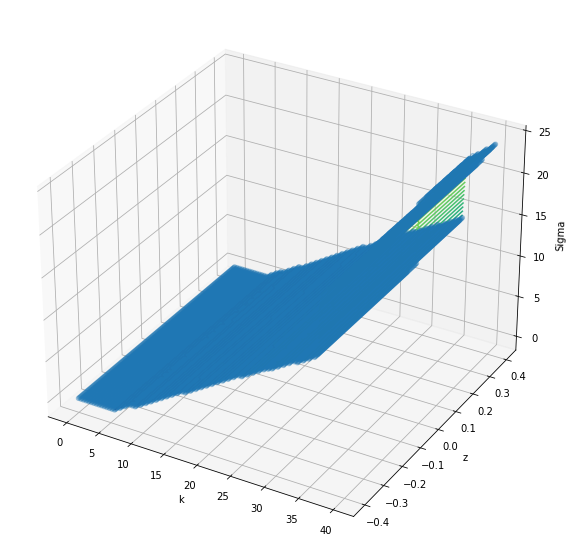

In [33]:
k, z = kgrid, zgrid
kk, zz = np.meshgrid(k, z)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.contour3D(kk, zz, ESigma2.T, 50)
ax.scatter(kk, zz, ESigma2.T, alpha=0.3)
ax.set_xlabel('k')
ax.set_ylabel('z')
ax.set_zlabel('Sigma');

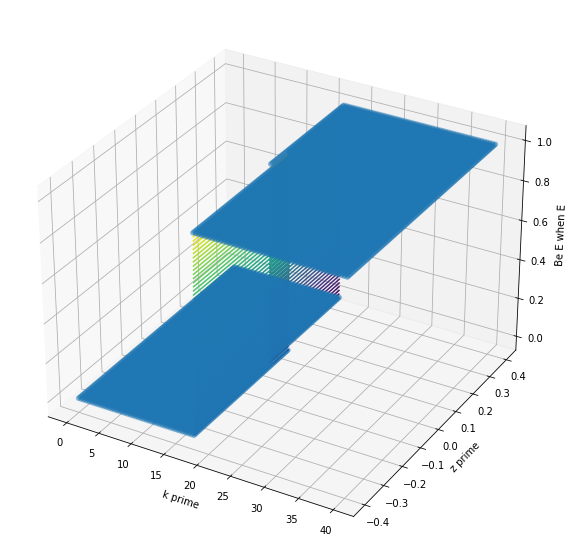

In [34]:
k, z = kgrid, zgrid
kk, zz = np.meshgrid(k, z)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.contour3D(kk, zz, EtoE.T, 50)
ax.scatter(kk, zz, EtoE.T, alpha=0.3)
ax.set_xlabel("k prime")
ax.set_ylabel("z prime")
ax.set_zlabel('Be E when E');

/var/folders/h3/8s40m8qn1t18bhvmz0czpj_m0000gn/T/ipykernel_78754/3304664920.py:8: UserWarning: No contour levels were found within the data range.
  ax.contour3D(kk, zz, WtoE_.T, 50)


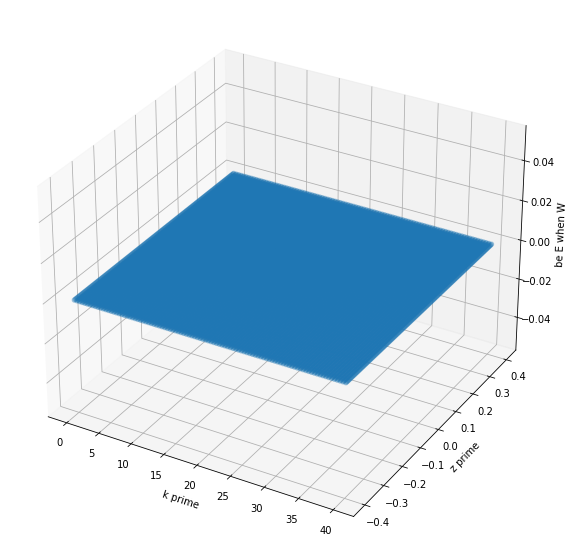

In [35]:
k, z = kgrid, zgrid
kk, zz = np.meshgrid(k, z)

WtoE_ = np.tile(WtoE, (ksize, 1))

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.contour3D(kk, zz, WtoE_.T, 50)
ax.scatter(kk, zz, WtoE_.T, alpha=0.3)
ax.set_xlabel('k prime')
ax.set_ylabel('z prime')
ax.set_zlabel('be E when W');

The following is to plot Entrepreneur's P matrix for visualization, checking for conditional normalization

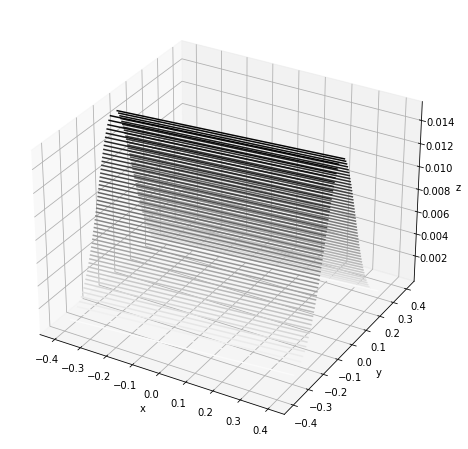

In [36]:
P = model.EP

x, y = zgrid, zgrid
X, Y = np.meshgrid(x, y)


fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, P.T, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');